In [3]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import signal
from google.colab import drive
import pandas as pd
import plotly.express as px

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = "drive/My Drive/TCC - Vinícius Franklin - Desenvolvimento de Prótese Ativa Controlada por Sinais EMG Utilizando Classificação com Machine Learning/Modelo - Análise/ECG"

# Carrega o CSV
df = pd.read_csv(path + "/data_ecg_2_ms.csv")


# Garante que os dados estão no formato numérico
df["tempo_arduino_ms"] = pd.to_numeric(df["tempo_arduino_ms"], errors="coerce")
df["valor_ADC"] = pd.to_numeric(df["valor_ADC"], errors="coerce")


In [6]:
df = df[round(len(df)*60/180):round(len(df)*160/180)]

In [7]:
df.reset_index(drop=True,inplace=True)

In [8]:

# Remove possíveis linhas inválidas
df = df.dropna()

# Converte tempo para segundos

df["tempo_arduino_s"] = df["tempo_arduino_ms"]/1000

periodo = float(df.loc[1,"tempo_arduino_s"] - df.loc[0,"tempo_arduino_s"])
sr = 1/periodo


# Cria o gráfico interativo
fig = px.line(df, x="tempo_arduino_s", y="valor_ADC", title="ECG - AD8232", labels={
    "tempo_s": "Tempo (s)",
    "valor": "Amplitude (ADC)"
})

# Mostra o gráfico no navegador
fig.show()


In [9]:
def plot_magnitude_spectrum(signal, sr, title, f_ratio=1):
    # FFT
    X = np.fft.fft(signal)
    X_mag = np.abs(X)

    # Frequência
    f = np.linspace(0, sr, len(X_mag))
    f_bins = int(len(X_mag) * f_ratio)




    # Plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=f[:f_bins//2],
        y=X_mag[:f_bins//2],
        mode='lines',
        name='Magnitude'
    ))

    fig.update_layout(
        title=title,
        xaxis_title='Frequency (Hz)',
        yaxis_title='Magnitude',
        width=900,
        height=400
    )

    fig.show()
    # retornar so a parte positiva, ja que é simetrico
    return X_mag[:f_bins//2],f,f_bins


In [10]:
values = df.valor_ADC.values

In [11]:
plot_magnitude_spectrum(values,sr,"Sinal do ADC Original")

(array([1.78824780e+07, 1.43069980e+04, 2.18161077e+04, ...,
        8.68666038e+03, 2.21724079e+03, 1.87619332e+03]),
 array([0.00000000e+00, 9.45948503e-03, 1.89189701e-02, ...,
        4.99981081e+02, 4.99990541e+02, 5.00000000e+02]),
 52858)

In [12]:
## primeiro filtro, tira a componente media

values = values - values.mean()

In [13]:
plot_magnitude_spectrum(values,sr,"Sinal do ADC Sem a Média")

(array([1.05774234e-09, 1.43069980e+04, 2.18161077e+04, ...,
        8.68666038e+03, 2.21724079e+03, 1.87619332e+03]),
 array([0.00000000e+00, 9.45948503e-03, 1.89189701e-02, ...,
        4.99981081e+02, 4.99990541e+02, 5.00000000e+02]),
 52858)

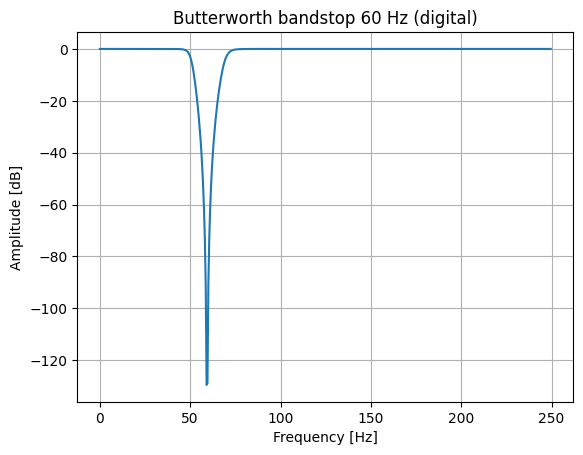

In [14]:
low = 50
high = 70
b, a = signal.butter(N=4, Wn=[low, high], btype='bandstop', fs=sr)

# Resposta em frequência digital
w, h = signal.freqz(b, a, fs=sr)
plt.plot(w, 20 * np.log10(abs(h)))
plt.title('Butterworth bandstop 60 Hz (digital)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.grid(True)
plt.show()

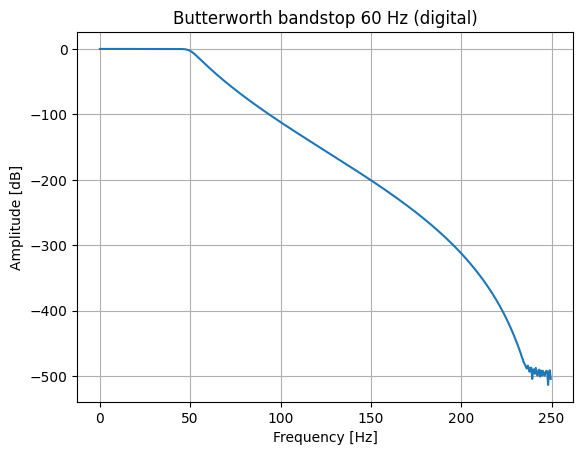

In [15]:
low = 50

b, a = signal.butter(N=16, Wn=low, btype='lowpass', fs=sr)

# Resposta em frequência digital
w, h = signal.freqz(b, a, fs=sr)
plt.plot(w, 20 * np.log10(abs(h)))
plt.title('Butterworth bandstop 60 Hz (digital)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.grid(True)
plt.show()

## FIR Filter (Passa Faixa)

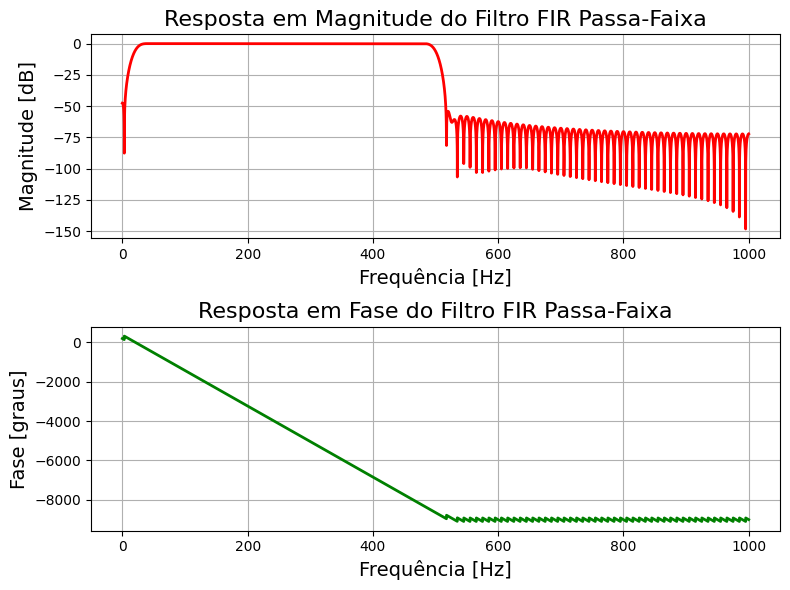

Coeficientes do filtro FIR (primeiros 10):
[ 3.12614952e-19 -2.41854235e-04  3.29504850e-05  3.19803940e-04
  6.89868640e-05 -1.98413237e-04  1.09928547e-04  4.44647629e-04
  1.57499420e-04 -1.59613225e-04]


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Parâmetros do filtro FIR passa-faixa
samp_freq = 2000  # Frequência de amostragem em Hz
low_cutoff = 20  # Frequência de corte inferior em Hz
high_cutoff = 500 # Frequência de corte superior em Hz
numtaps = 201     # Número de coeficientes do filtro FIR

# Projeto do filtro FIR passa-faixa usando firwin
b_fir = signal.firwin(numtaps, [low_cutoff, high_cutoff], pass_zero=False, fs=samp_freq)

# Resposta em frequência do filtro
freq, h = signal.freqz(b_fir, worN=8000, fs=samp_freq)

# Calcula a fase em graus
Phase = np.unwrap(np.angle(h)) * (180 / np.pi)

# Plotagem da resposta em magnitude e fase
fig = plt.figure(figsize=(8, 6))

# Subplot 1: Magnitude
sub1 = plt.subplot(2, 1, 1)
sub1.plot(freq, 20 * np.log10(abs(h)), 'r', linewidth=2, label='Filtro FIR Passa-Faixa')
sub1.set_xlabel('Frequência [Hz]', fontsize=14)
sub1.set_ylabel('Magnitude [dB]', fontsize=14)
sub1.set_title('Resposta em Magnitude do Filtro FIR Passa-Faixa', fontsize=16)
sub1.grid()

# Subplot 2: Fase
sub2 = plt.subplot(2, 1, 2)
sub2.plot(freq, Phase, 'g', linewidth=2)
sub2.set_xlabel('Frequência [Hz]', fontsize=14)
sub2.set_ylabel('Fase [graus]', fontsize=14)
sub2.set_title('Resposta em Fase do Filtro FIR Passa-Faixa', fontsize=16)
sub2.grid()

plt.tight_layout()
plt.show()

# Exibe os primeiros coeficientes do filtro
print("Coeficientes do filtro FIR (primeiros 10):")
print(b_fir[:10])

## IIR (Passa Faixa)

/tmp/ipython-input-291499623.py:25: RuntimeWarning:

divide by zero encountered in log10



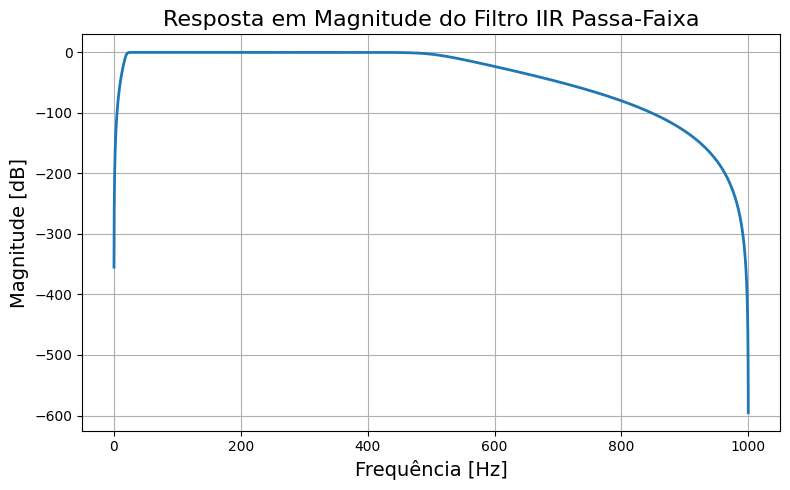

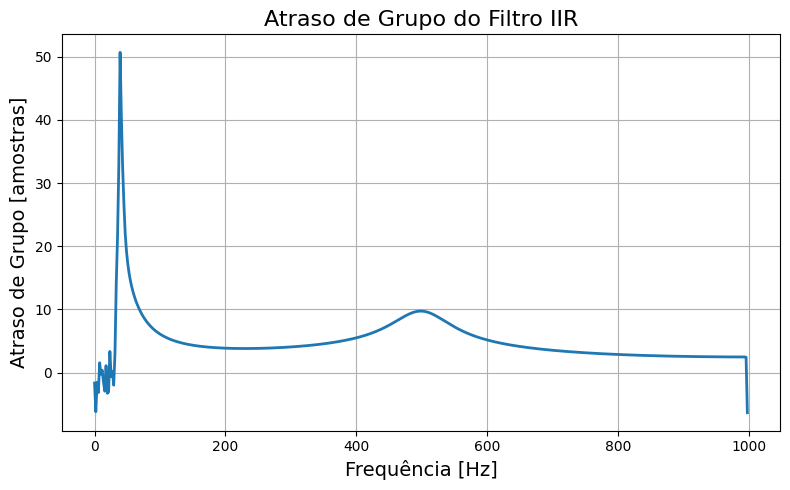

Primeiro estágio SOS: [ 0.00717066  0.01434132  0.00717066  1.         -0.06480958  0.01218541]


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Parâmetros do filtro IIR passa-faixa
samp_freq = 2000  # Exemplo (substituir pelo seu sr real)
low_cutoff = 20   # Hz
high_cutoff = 500 # Hz
order = 8

# Projeto do filtro IIR Butterworth (SOS)
sos = signal.butter(
    N=order,
    Wn=[low_cutoff, high_cutoff],
    btype='bandpass',
    fs=samp_freq,
    output='sos'
)

# Resposta em frequência
freq, h = signal.sosfreqz(sos, worN=8000, fs=samp_freq)

# ======== PLOT 1: MAGNITUDE =========
plt.figure(figsize=(8, 5))
plt.plot(freq, 20 * np.log10(abs(h)), linewidth=2)
plt.title("Resposta em Magnitude do Filtro IIR Passa-Faixa", fontsize=16)
plt.xlabel("Frequência [Hz]", fontsize=14)
plt.ylabel("Magnitude [dB]", fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()

# ======== CÁLCULO DO ATRASO DE GRUPO =========
# Precisamos converter o SOS para (b, a)
b, a = signal.sos2tf(sos)

# group_delay retorna: frequências (Hz) e atraso (amostras)
w_gd, gd = signal.group_delay((b, a), fs=samp_freq)

# ======== PLOT 2: ATRASO DE GRUPO =========
plt.figure(figsize=(8, 5))
plt.plot(w_gd, gd, linewidth=2)
plt.title("Atraso de Grupo do Filtro IIR", fontsize=16)
plt.xlabel("Frequência [Hz]", fontsize=14)
plt.ylabel("Atraso de Grupo [amostras]", fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()

# Exibir coeficientes do primeiro estágio SOS
print("Primeiro estágio SOS:", sos[0])


# IIR Filter

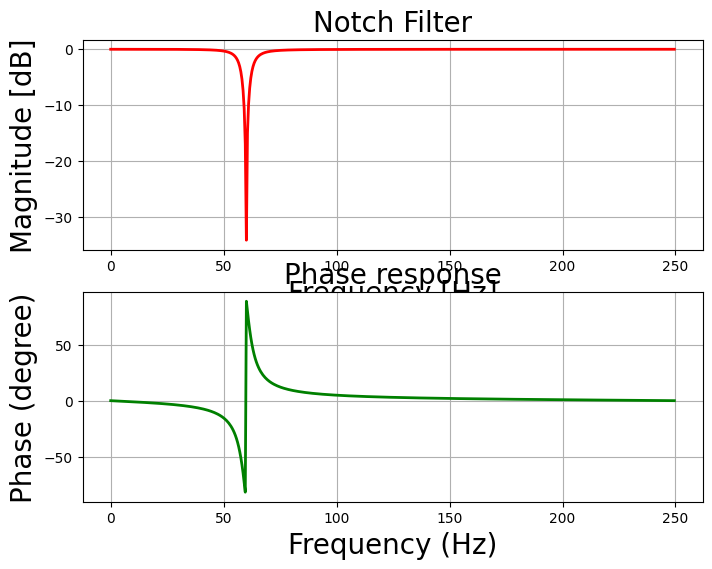

In [19]:
# Design a notch filter using signal.iirnotch
notch_freq = 60
quality_factor = 10
samp_freq = sr
b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, samp_freq)

# Compute magnitude response of the designed filter
freq, h = signal.freqz(b_notch, a_notch, fs=2*np.pi)

# Calculate phase angle in degree from hz
Phase = np.unwrap(np.arctan2(np.imag(h),
                                 np.real(h)))*(180/np.pi)

fig = plt.figure(figsize=(8, 6))

sub1 = plt.subplot(2, 1, 1)
# Plot magnitude response of the filter
sub1.plot(freq*samp_freq/(2*np.pi), 20 * np.log10(abs(h)),
         'r', label='Bandpass filter', linewidth='2')

sub1.set_xlabel('Frequency [Hz]', fontsize=20)
sub1.set_ylabel('Magnitude [dB]', fontsize=20)
sub1.set_title('Notch Filter', fontsize=20)
sub1.grid()

sub2 = plt.subplot(2, 1, 2)

sub2.plot(freq*samp_freq/(2*np.pi), Phase, 'g', linewidth=2)
sub2.set_ylabel('Phase (degree)', fontsize=20)
sub2.set_xlabel(r'Frequency (Hz)', fontsize=20)
sub2.set_title(r'Phase response', fontsize=20)
sub2.grid()


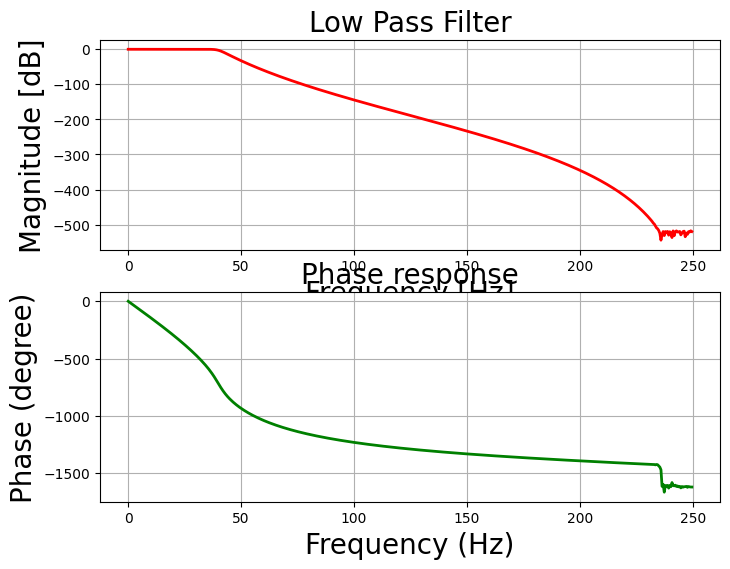

In [20]:
low = 40
b, a = signal.butter(N=16, Wn=low, btype='lowpass', fs=sr)

# Resposta em frequência digital
w, h = signal.freqz(b, a, fs=sr)

# Calculate phase angle in degree from hz
Phase = np.unwrap(np.arctan2(np.imag(h),
                                 np.real(h)))*(180/np.pi)


fig = plt.figure(figsize=(8, 6))

sub1 = plt.subplot(2, 1, 1)
# Plot magnitude response of the filter
sub1.plot(freq*samp_freq/(2*np.pi), 20 * np.log10(abs(h)),
         'r', label='Low Pass filter', linewidth='2')

sub1.set_xlabel('Frequency [Hz]', fontsize=20)
sub1.set_ylabel('Magnitude [dB]', fontsize=20)
sub1.set_title('Low Pass Filter', fontsize=20)
sub1.grid()

sub2 = plt.subplot(2, 1, 2)

sub2.plot(freq*samp_freq/(2*np.pi), Phase, 'g', linewidth=2)
sub2.set_ylabel('Phase (degree)', fontsize=20)
sub2.set_xlabel(r'Frequency (Hz)', fontsize=20)
sub2.set_title(r'Phase response', fontsize=20)
sub2.grid()

# Sem Fase Zero IIR

In [21]:
sr = 1/(2*10**-3)
low = 50
high = 70

# Butterworth bandstop como Second-Order Sections
sos = signal.butter(N=8, Wn=[low, high], btype='bandstop', fs=sr, output='sos')

# Aplica o filtro
filtered = signal.sosfilt(sos = sos, x = values)

In [22]:
  sr = 1/(2*10**-3)
  low = 28

  # Butterworth bandstop como Second-Order Sections
  sos = signal.butter(N=32, Wn=low, btype='lowpass', fs=sr,output='sos')

  # Aplica o filtro
  filtered_2 = signal.sosfilt(sos=sos, x=filtered)

In [23]:
sr = 1/(2*10**-3)
low = 10

# Butterworth bandstop como Second-Order Sections
sos = signal.butter(N=0, Wn=low, btype='lowpass', fs=sr,output='sos')

# Aplica o filtro
filtered_3 = signal.sosfilt(sos=sos, x=filtered_2)

In [24]:
X_mag_ecg ,f_ecg ,f_bins_ecg= plot_magnitude_spectrum(filtered_3,sr,"ECG filtrado")


In [25]:
import pandas as pd
import plotly.express as px

df_filtered = pd.DataFrame({
    "tempo_s": df["tempo_arduino_s"],
    "ECG_filtrado": filtered_3
})

df_filtered = df_filtered[round(len(df_filtered)*0.6):round(len(df_filtered)*0.7)]

fig = px.line(df_filtered, x="tempo_s", y="ECG_filtrado",
              title="ECG Filtrado - AD8232",
              labels={"tempo_s": "Tempo (s)", "ECG_filtrado": "Amplitude"})
fig.show()


# Com Fase Zero IIR

In [26]:
sr = 1/(2*10**-3)
low = 50
high = 70

# Butterworth bandstop como Second-Order Sections
sos = signal.butter(N=16, Wn=[low, high], btype='bandstop', fs=sr, output='sos')

# Aplica o filtro
filtered = signal.sosfiltfilt(sos = sos, x = values)


In [27]:
sr = 1/(2*10**-3)
low = 30

# Butterworth bandstop como Second-Order Sections
sos = signal.butter(N=32, Wn=low, btype='lowpass', fs=sr,output='sos')

# Aplica o filtro
filtered_2 = signal.sosfiltfilt(sos=sos, x=filtered)

In [28]:
#sr = 1/(2*10**-3)
#low = 33
#
## Butterworth bandstop como Second-Order Sections
#sos = signal.butter(N=0, Wn=low, btype='lowpass', fs=sr,output='sos')
#
## Aplica o filtro
#filtered_3 = signal.sosfiltfilt(sos=sos, x=filtered_2)

In [29]:
def simple_moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    sma = np.convolve(data, weights, mode='same')
    return sma

# Calculate SMA with window size of 3
window_size = 6
mm_values = simple_moving_average(filtered_2, window_size)
#print("Simple Moving Average:", sma)

In [30]:
X_mag_ecg ,f_ecg ,f_bins_ecg = plot_magnitude_spectrum(mm_values,sr,"ECG filtrado")


In [31]:
np.mean(mm_values[:])

np.float64(0.006371240862898156)

In [32]:
X_mag_ecg ,f_ecg ,f_bins_ecg = plot_magnitude_spectrum(mm_values[round(len(df_filtered)*0.645):round(len(df_filtered)*0.69)]-np.mean(mm_values[round(len(df_filtered)*0.645):round(len(df_filtered)*0.69)]),sr,"ECG filtrado")


In [33]:
import pandas as pd
import plotly.express as px

df_filtered = pd.DataFrame({
    "tempo_s": df["tempo_arduino_s"],
    "ECG_filtrado": mm_values
})


fig = px.line(df_filtered[round(len(df_filtered)*0.645):round(len(df_filtered)*0.69)], x="tempo_s", y="ECG_filtrado",
              title="ECG Filtrado - AD8232 (De 64,5% a 69% do sinal)",
              labels={"tempo_s": "Tempo (s)", "ECG_filtrado": "Amplitude"})
fig.show()

Para a criação dos fitros e definição dos parâmetros foi basicamente analisado o fourier, tirando o que de cara já parecia errado, como componente media e 60 hz da rede, e depois foi sendo analisado o sinal, colocando um passa baixas e para este ser o melhor possivel para a onda do ecg ser a mais fidediguena possivel tem que meio que ir testanto na mao os paramentros de ordem e frequencia de corte, de modo a otimizar a qualidade do sinal, importante tambem ser fase 0, pois o iir causa alteracao de fase que para este caso que queremos observar no tempo daria muito problema, e o fir nao atende é muito simples
no final usamos um media movel de ordem muito baixa so para dar um toque final

## Comparação do Filtrado x Não Filtrado

In [34]:
fig = px.line(df_filtered, x="tempo_s", y="ECG_filtrado",
              title="ECG Filtrado - AD8232",
              labels={"tempo_s": "Tempo (s)", "ECG_filtrado": "Amplitude"})
fig.show()

In [35]:
fig = px.line(df, x="tempo_arduino_s", y="valor_ADC",
              title="ECG Filtrado - AD8232",
              labels={"tempo_s": "Tempo (s)", "ECG_filtrado": "Amplitude"})
fig.show()

Percebemos a melhora absurda na qualidade, o sinal agora se assemelha bastante com o desejado, podemos perceber o pico QRS, em alguns pontos podemos observar a onda T um pouco maior que o desejado. Isso poderia ser melhorado se fizermos mais testes, ou tentar retirar alguma frequencia especifica, mas já é um muito bom resultado, e serve para qualquer pessoa
Podemos obter os batimentos atraves da frequencia fundamental, ou pela distancia entre picos

Proximo passo é extrair features deste dataset, esta no outro arquivo

Para criar um modelo para detectar anomalias teria que melhorar um pouco os filtros, so por causa de alguns picos T que estao mais altos do que deveria

texto para colocar no readme


Este rep traz o procedimento e aplicação para captação de um eletrocardiograma utilizando um AD8232 módulo ecg.
Nele temos o código bem basico em arduino, utilizando a frequencia de amostragem respeitando a de nyquist de 500hz, tendo em vista que a frequencia normal de sinais ecg não ultrapassam 250hz, com arduino poderiamos ate trabalhar com frequencias de amostragem maiores
depois disso utilizamos um codigo em python para ler os dados do monitor serial que seriam jogados pelo .ino e escrever em um csv, no monitor serial pelo .ino printamos o valor adc e o tempo, assim podemos ter certeza tambem da frequencia e periodo de amostragem
depois disso criamos um arquivo de leitura, vemos um sinal completamente perdido e sem muito sentido, para trabalharmos com ele usamos diversas tecnicas de dsp utilizando fourier para entendermos nosso problema, no final usamos:

tirar a componente media
filtro rejeita faixa para tirar a frequencia da rede
filtro passa baixas para tirar componentes de alta frequencia
media movel de baixa ordem

utilizamos filtros iir mas com fase zero, compensando, como é offline podemos usar, pois aqui conseguimos usar este mesmo sendo não causal pegando dados futuros pois temos este já que é uma base de dados não dados em tempo real

inclusive temos a comparcao de um filro iir normal, e um filtro fase zero no arquivo, percebemos a grande diferença

se quisessemos usar os coeficientes a e b teriamos que pensar em outra solucao, poderiamos por exemplo atrasar o sinal para criarmos um futurismo, ai conseguiriamos ter as amostras futuras, serial um semi real time, com certo atraso

depois de filtrar podemos extrair facilmente o batimento por minuto bpm pela frequencia fundamental ou intervalo entre picos obtendo o periodo depois converte, ambos estariam em hz mas é só multiplicar por 60.

neste repositorio entao temos:

Um arquivo em read_ecg.ino para obtencao do sinal, bem basica mesmo atraves do adc e monitor serial usando um arduino

arquivo para ler o monitor serial serial_monitor.ipynb para ler os dados enviados pelo arduino via monitor serial, forma mais simples de obtencao dos dados

arquivo em Digital_Siganl_Processing.ipynb para ler o monitor serial e gravar em um .csv

feature_extraction.ipynb para fazer o processamento de sinal digital e salvar este em um novo .csv

nome_arquivo.csv para fazer a estração de features e salvar essa tabela em um csv

Para usar pode-se apenas usar os csv's sem necessidade de realmente obter os dados com arduino, mas claro que pode fazer isso caso necessario

Um proximo passo seria tentar usar o modelo para descobrir desturbios, no caso arritimias

In [36]:
salvar = input("Salvar? (S/N)")
if salvar == "S":
  # Salva em CSV
  df_filtered.to_csv("ECG_filtrado.csv", index=False)
  print("Arquivo ECG_filtrado.csv salvo com sucesso!")


Salvar? (S/N)9
